In [1]:
import mitsuba as mi
import drjit as di
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchmetrics.functional import structural_similarity_index_measure as ssim
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
from PIL import Image
from unet import UNet,UNet1
from utils import load_trainData

In [2]:
images, images_labels = load_trainData(1502,"./data/dataSet")
images = torch.tensor(np.transpose(images,(0,3,2,1)),dtype=torch.float)
images_labels = torch.tensor(np.transpose(images_labels,(0,3,2,1)),dtype=torch.float)
print(images.shape)
print(images_labels.shape)

torch.Size([1502, 13, 512, 384])
torch.Size([1502, 3, 512, 384])


In [3]:
class MyLoss(nn.Module):
    def __init__(self, Lc_weight, Le_weight, Lt_weight):
        super(MyLoss, self).__init__()
        self.Lc_weight = Lc_weight
        self.Le_weight = Le_weight
        self.Lt_weight = Lt_weight
        # self.ssim_loss = pytorch_ssim.SSIM()
        kernel = torch.tensor([[[-1, -1, -1], 
                                [-1,  8, -1], 
                                [-1, -1, -1]]], dtype=torch.float32)
        kernel = kernel.expand(3, 1, 3, 3)
        self.laplacian_filter = nn.Conv2d(3, 3, kernel_size=3, padding=1,groups=3, bias=False)
        self.laplacian_filter.weight = nn.Parameter(kernel, requires_grad=False)
        # self.tv_l1 = TVL1()

    def forward(self, output, target):
        # Lc: SSIM loss
        Lc = 1 - ssim(output, target)
        
        # Le: L1 difference after applying Laplacian filter
        output_laplacian = self.laplacian_filter(output)
        target_laplacian = self.laplacian_filter(target)
        Le = F.l1_loss(output_laplacian, target_laplacian)

        # L = F.l1_loss(output,target)

        # Combined loss
        loss =   self.Le_weight * Le + Lc

        return loss

In [4]:


device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

batch_size = 16
lr = 0.0001
num_epochs = 200
customedLoss = MyLoss(0.7,0.1,0.2).to(device)
unet = UNet(10,3)
unet.load_state_dict(torch.load('./models_trained/unet_with_Le_Lssim_200.pth'))
unet = unet.to(device)
optimizer = optim.Adam(unet.parameters(),lr=lr,betas=(0.9, 0.999))

In [5]:


class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # 获取单个图像数据
        label = self.labels[idx]  # 获取对应的标签数据
        return image, label

# 创建 Dataset 实例
dataset = CustomDataset(images, images_labels)

dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

C:\Users\RTProject\AppData\Local\Temp\ipykernel_7572\2753107054.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  test_images = torch.tensor(test_images,dtype=torch.float).to(device)


torch.Size([3, 13, 512, 384])


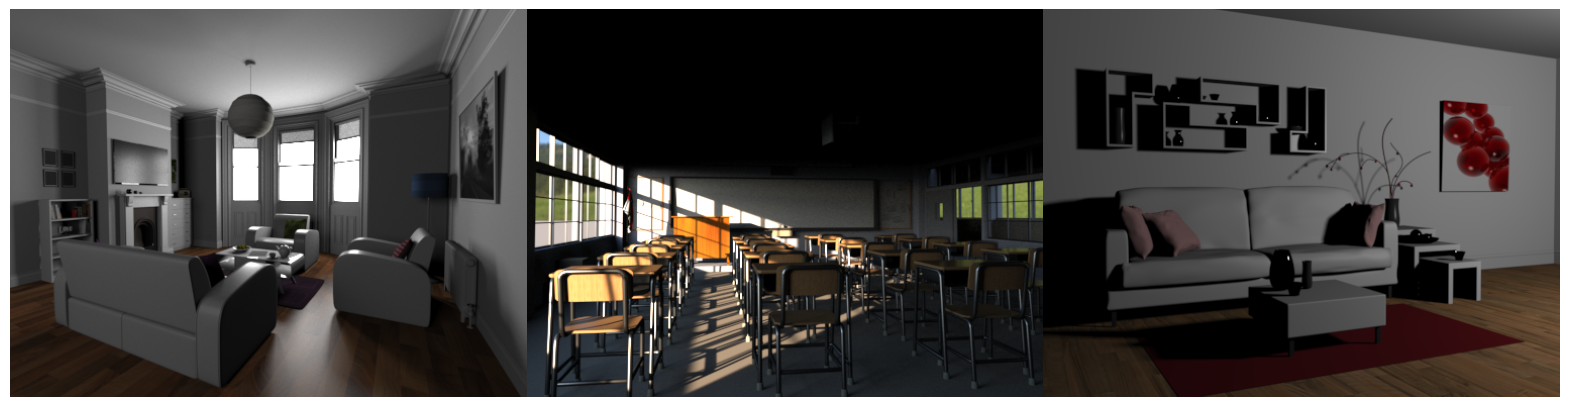

In [6]:
mi.set_variant("cuda_ad_rgb")
scene1 = mi.load_file("./complex_scenes/living-room-2/living-room-2/scene_v3.xml")
scene2 = mi.load_file("./complex_scenes/classroom/classroom/scene_v3.xml")
scene3 = mi.load_file("./complex_scenes/living-room-3/living-room-3/scene_v3.xml")
# 生成测试图片
aov_integrator = mi.load_dict({
    'type':'aov',
    'aovs':'position:position,normal:sh_normal,depth:depth,albedo:albedo',
    'my_image':{
        'type':'path',
        'max_depth':2
    }
})
test_images=[]
test_images.append(np.array(mi.render(scene1,integrator=aov_integrator,spp=4096)))
test_images.append(np.array(mi.render(scene2,integrator=aov_integrator,spp=4096)))
test_images.append(np.array(mi.render(scene3,integrator=aov_integrator,spp=4096)))

# 设置图形大小
fig = plt.figure(figsize=(20, 10))
# 设置子图间距
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(np.clip((test_images[i][:, :, :3])**(1.0/2.2),0,1))
    ax.axis('off')  # 关闭坐标轴
    test_images[i] = np.transpose(test_images[i],(2,1,0))
test_images = torch.tensor(test_images,dtype=torch.float).to(device)
print(test_images.shape)

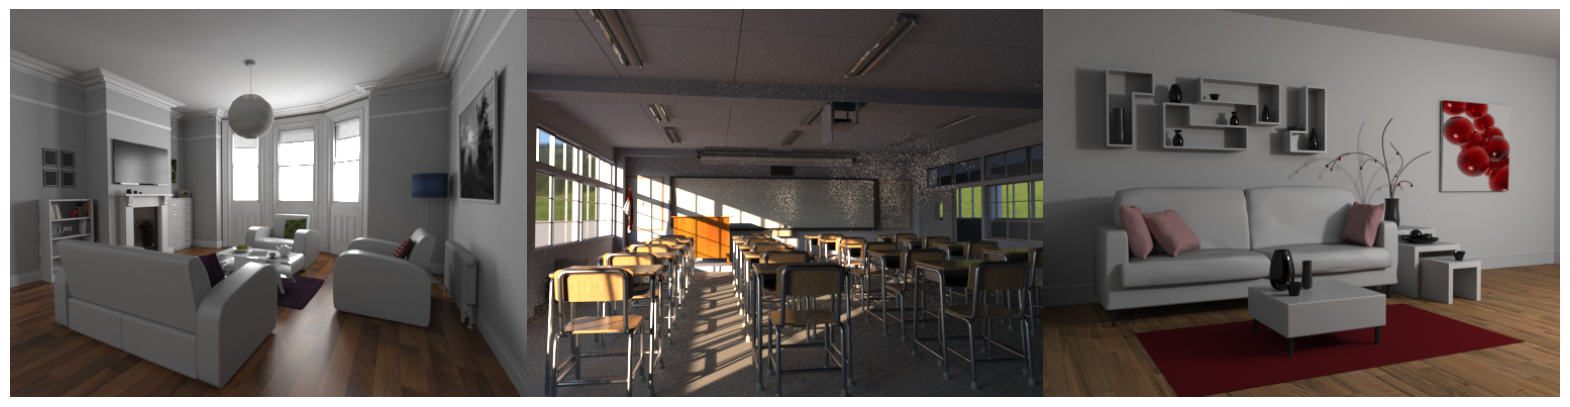

In [7]:

_integrator = mi.load_dict({
    'type':'path',
    'max_depth':3
})
scenes = [scene1,scene2,scene3]
images = [mi.render(scene,integrator=_integrator,spp=4096) for scene in scenes]
images = np.array(images)
# 设置图形大小
fig = plt.figure(figsize=(20, 10))
# 设置子图间距
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(np.clip((images[i][:, :, :3])**(1.0/2.2),0,1))
    ax.axis('off')  # 关闭坐标轴

In [ ]:

loss_list = []
for epoch in range(num_epochs):
    unet.train()
    total_loss = 0.0
    count = 0
    with tqdm(dataloader,unit="batch") as tepoch:
        for image,label in tepoch:
            image =image.to(device)
            label = label.to(device)
            if torch.isnan(image).any():
                continue
            optimizer.zero_grad()
            out = unet(image[:,:10,:,:])
            out = F.sigmoid(out)
            out = out*image[:,10:13,:,:]   #乘上albedo得到间接光照结果

            loss = customedLoss(out,label)
            loss_list.append(loss.item())
            loss.backward()

            total_loss += loss.item()
            count+=1

            optimizer.step()
            tepoch.set_postfix(loss=loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/count:.4f}')
    # 可视化结果
    if epoch%2 == 0:
        unet.eval()
        out = unet(test_images[:,:10,:,:])
        out = F.sigmoid(out)
        out = ((out * test_images[:,10:13,:,:])+test_images[:,:3,:,:]).squeeze(0)
        
        out = out.permute(0,3,2,1).cpu().detach().numpy()

        img = np.clip(out**(1.0/2.2), 0, 1) * 255
        img = img.astype(np.uint8)  # 将数据类型转换为 uint8

        images = [Image.fromarray(img[i,:, :, :]) for i in range(3)]

        single_width, single_height = images[0].size
        total_width = single_width * len(images)
        total_height = single_height
        combined_image = Image.new('RGB', (total_width, total_height))
        # 将每张图像粘贴到新的空白图像上
        for i, img in enumerate(images):
            combined_image.paste(img, (i * single_width, 0))

        combined_image.save(f"./results/results_unet/{epoch}.png")
    if epoch%100 == 0:
        torch.save(unet.state_dict(),f'./unet_with_Le_Lssim_{epoch}.pth')
        

In [ ]:
# 生成 epoch 数的列表
epochs = list(range(1, len(loss_list) + 1))

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()